# Result

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

%matplotlib inline

In [2]:
from methods.evaluation import Evaluation, EvaluationPrecision, EvaluationRecall, EvaluationFscore

In [3]:
domains = ['eclipse', 'netbeans', 'openoffice', 'firefox'] # '' 
PREPROCESSING = 'bert'
methods = { 
            '20' : ['baseline_20', 'baseline_dwen_20', 
               'deepTL_20', 'DWEN_QL_20', #'propose_centroid_bert_triplet_20', 
                    'deepQL_weights_20', 'DMS_QL_20', #'deepQL_20',
                    'deepCL_20', 'fasttext_20'], # 'baseline_triplet_hard_20'
            '100' : ['baseline_100', 'baseline_dwen_100', #'deepQL_100',
               'deepTL_100', 'DWEN_QL_100', 'deepQL_weights_100', 'DMS_QL_100',
                     'deepCL_100', 'fasttext_100'], # 'baseline_triplet_hard_100' 'propose_centroid_bert_triplet_100'
           # 'propose_100', 'propose_bert_100', 'propose_softmax_100', 'propose_master_triplet_loss_100'
           '1000' : ['baseline_1000', 'baseline_dwen_1000', #'deepQL_1000',
               'deepTL_1000', 'DWEN_QL_1000', 'deepQL_weights_1000', 'DMS_QL_1000',
                     'deepCL_1000', 'fasttext_1000'] # 'baseline_triplet_hard_1000' 'propose_centroid_bert_triplet_1000'
           #  'propose_bert_1000', 'propose_1000', 'propose_softmax_1000', 'propose_master_triplet_loss_1000'
          }
authors = { 
            'baseline_triplet_hard_20' : '(Hard) Deshmukh et al. (2017)',
            'baseline_triplet_hard_100' : '(Hard) Deshmukh et al. (2017)',
            'baseline_triplet_hard_1000' : '(Hard) Deshmukh et al. (2017)',
            'baseline_20': 'DMS', # Deshmukh et al. (2017) 
            'baseline_100': 'DMS', 
           'baseline_1000': 'DMS', 
           'baseline_dwen_20': 'DWEN', # Budhiraja et al. (2018)
            'baseline_dwen_100': 'DWEN',
           'baseline_dwen_1000': 'DWEN',
           'propose_20': 'P-TL-MLP+CNN+BiLSTM+Residual',
           'propose_100': 'P-TL-MLP+CNN+BiLSTM+Residual',
           'propose_1000': 'P-TL-MLP+CNN+BiLSTM+Residual',
           'propose_softmax_100': 'P-TL-Softmax',
           'propose_softmax_1000': 'P-TL-Softmax',
           'propose_master_triplet_loss_100': 'P-QL-MLP+CNN+BiLSTM+Residual',
           'propose_master_triplet_loss_1000': 'P-QL-MLP+CNN+BiLSTM+Residual',
           'propose_bert_20' : 'P-QL-MLP+BERT',
           'propose_bert_100' : 'P-QL-MLP+BERT',
           'propose_bert_1000' : 'P-QL-MLP+BERT',
           'deepTL_20' : 'DeepTL', # P-Propose, Triplet Loss-TL
           'deepTL_100' : 'DeepTL', # P-Propose, Triplet Loss-TL
           'deepTL_1000' : 'DeepTL',
           'propose_centroid_bert_triplet_20' : "P-TLC-MLP+BERT",
           'propose_centroid_bert_triplet_100' : "P-TLC-MLP+BERT",
           'propose_centroid_bert_triplet_1000' : "P-TLC-MLP+BERT",
           'DWEN_QL_20' : 'DWEN_QL',
           'DWEN_QL_100' : 'DWEN_QL',
           'DWEN_QL_1000' : 'DWEN_QL',
            'deepQL_weights_20' : 'DeepQL_Weights',
            'deepQL_weights_100' : 'DeepQL_Weights',
            'deepQL_weights_1000' : 'DeepQL_Weights',
            'DMS_QL_20' : 'DMS_QL',
            'DMS_QL_100' : 'DMS_QL',
            'DMS_QL_1000' : 'DMS_QL',
            'deepQL_20' : 'DeepQL',
            'deepQL_100' : 'DeepQL',
            'deepQL_1000' : 'DeepQL',
           'deepCL_20': 'DeepCL',
           'deepCL_100': 'DeepCL',
           'deepCL_1000': 'DeepCL',
           'fasttext_20': 'FastText',
            'fasttext_100': 'FastText',
           'fasttext_1000': 'FastText'
          }
markers = {
            'propose_centroid_bert_triplet_20' : "4",
           'propose_centroid_bert_triplet_100' : "4",
           'propose_centroid_bert_triplet_1000' : "4",
           'baseline_triplet_hard_20' : '3',
            'baseline_triplet_hard_100' : '3',
           'baseline_triplet_hard_1000' : '3',
           'baseline_20': '.', 
           'baseline_100': '.', 
           'baseline_1000': '.', 
           'baseline_dwen_20': '^',
           'baseline_dwen_100': '^',
           'baseline_dwen_1000': '^',
           'propose_20': '8',
           'propose_100': '8',
           'propose_1000': '8',
           'propose_softmax_20': '1',
           'propose_softmax_100': '1',
           'propose_softmax_1000': '1',
           'propose_master_triplet_loss_20': 'p',
           'propose_master_triplet_loss_100': 'p',
           'propose_master_triplet_loss_1000': 'p',
           'propose_bert_20' : 's',
           'propose_bert_100' : 's',
           'propose_bert_1000' : 's',
           'deepTL_20' : 'D', # P-Propose, Triplet Loss-TL
           'deepTL_100' : 'D', # P-Propose, Triplet Loss-TL
           'deepTL_1000' : 'D',
           'DWEN_QL_20' : '4',
           'DWEN_QL_100' : '4',
           'DWEN_QL_1000' : '4',
            'deepQL_20' : '*',
            'deepQL_100' : '*',
            'deepQL_1000' : '*',
            'deepQL_weights_20' : '3',
            'deepQL_weights_100' : '3',
            'deepQL_weights_1000' : '3',
            'DMS_QL_20' : '4',
            'DMS_QL_100' : '4',
            'DMS_QL_1000' : '4',
            'deepCL_100': '3',
           'deepCL_1000': '3',
           'fasttext_100': '4',
           'fasttext_1000': '4'
}

### Retrieval 

In [4]:
def evaluate_rank(evaluation, method, domain, epoch, aproach, recall, recall_index, epochs, datasets, symbols, path):
    #evaluation = Evaluation(0)
    try:
        if(path != ''):
            report = evaluation.evaluate(path)
        else:
            report = evaluation
        recall.append(report['1 - recall_at_5'])
        recall.append(report['2 - recall_at_10'])
        recall.append(report['3 - recall_at_15'])
        recall.append(report['4 - recall_at_20'])
        recall.append(report['5 - recall_at_25'])
        aproach += [authors[method]] * 5
        symbols += [markers[method]] * 5
        datasets += [domain] * 5
        epochs += [epoch] * 5
        recall_index += [5, 10, 15, 20, 25]
        print(path)
        return report
    except Exception as e:
        print(e)
        print("Does not exist result for: {}".format(path))
        return
def create_dataframe(rank):
    recall = [] # recall binary
    recall_classic = [] # recall with groundtruth
    precision = []
    fscore = []
    fscore_classic = []
    aproach, recall_index, datasets, epochs, symbols = [], [], [], [], []
    df = pd.DataFrame(columns=['recall', 'precision', 'f_score', 'top@k', 'method', 'domain', 'epoch', 'symbol'])

    for epoch in ['20', '100', '1000']:
        for domain in domains:
            # Domain to use
            DOMAIN = domain
            # Dataset paths
            DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
            for method in methods[epoch]:
                path = os.path.join(DIR, '{}_{}.txt'.format(rank, method))
                report_recall = evaluate_rank(Evaluation(0), method, domain, epoch, aproach, recall, recall_index, epochs, datasets, symbols, path)
                report_precision = evaluate_rank(EvaluationPrecision(0), method, domain, epoch, [], precision, [], [], [], [], path)
#                 report_recall_classic = evaluate_rank(EvaluationRecall(0), epoch, domain, recall_classic, [], path)
                if(report_precision != None and report_recall != None):
                    report_fscore = evaluate_rank(EvaluationFscore().evaluate(report_precision, report_recall), method, domain, epoch, [], fscore, [], [], [], [], '')
    
    df['recall'] = recall
    df['precision'] = precision
    df['f_score'] = fscore
    df['top@k'] = recall_index
    df['method'] = aproach
    df['domain'] = datasets
    df['epoch'] = epochs
    df['symbol'] = symbols
    return df

In [5]:
df = create_dataframe('exported_rank')
df_master = create_dataframe('exported_rank_master')

[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_dwen_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_dwen_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_dwen_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_dwen_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_deepTL_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_deepTL_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported

data/processed/eclipse/bert/exported_rank_baseline_100.txt
data/processed/eclipse/bert/exported_rank_baseline_100.txt

[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_dwen_100.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_dwen_100.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_dwen_100.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_dwen_100.txt
data/processed/eclipse/bert/exported_rank_deepTL_100.txt
data/processed/eclipse/bert/exported_rank_deepTL_100.txt

[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_DWEN_QL_100.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_DWEN_QL_100.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_DWEN_QL_100.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_DWEN_QL_100.txt
data/processed

data/processed/eclipse/bert/exported_rank_baseline_1000.txt
data/processed/eclipse/bert/exported_rank_baseline_1000.txt

[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_dwen_1000.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_dwen_1000.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_baseline_dwen_1000.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_baseline_dwen_1000.txt
data/processed/eclipse/bert/exported_rank_deepTL_1000.txt
data/processed/eclipse/bert/exported_rank_deepTL_1000.txt

[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_DWEN_QL_1000.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_DWEN_QL_1000.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_DWEN_QL_1000.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_DWEN_QL_1000.txt
da

[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_master_baseline_dwen_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_master_baseline_dwen_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_master_deepTL_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_master_deepTL_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_master_deepTL_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_master_deepTL_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_master_DWEN_QL_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_master_DWEN_QL_20.txt
[Errno 2] No such file or directory: 'data/processed/eclipse/bert/exported_rank_master_DWEN_QL_20.txt'
Does not exist result for: data/processed/eclipse/bert/exported_rank_master_DWEN_QL_20.txt
[Errno 2] No such file

### Markers

https://matplotlib.org/3.1.1/api/markers_api.html

# Duplicate Test

## 100 epochs

In [6]:
df_100 = df[df['epoch'] == '100']

In [7]:
import matplotlib.ticker as mticker

MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def build_100_epochs(metric):
    # equivalent but more general
    fig, axes = plt.subplots(nrows=1, ncols=len(domains), figsize=(22, 5))

    for index, domain in enumerate(domains):
        aproachs = df_100['method'].unique()
        for method in aproachs:
            experiment = df_100[(df_100['method'] == method) & (df_100['domain'] == domain)]
            if experiment.shape[0] > 0:
                experiment.plot(x='top@k', y=metric, label=method, ax=axes[index], 
                                marker=experiment['symbol'].values[0], markersize=12)

        axes[index].set_ylabel('{} Rate'.format(metric))
        axes[index].set_xlabel('K')
        text = axes[index].set_title('{}'.format(domain))
        lgd = axes[index].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18))
        formatter = mticker.ScalarFormatter()
        axes[index].xaxis.set_major_formatter(formatter)
        axes[index].xaxis.set_major_locator(mticker.FixedLocator([5, 10, 15, 20, 25]))
        axes[index].grid(True, axis='y', alpha=.5)

    fig.savefig('retrieval_100.png', bbox_inches="tight")

No handles with labels found to put in legend.


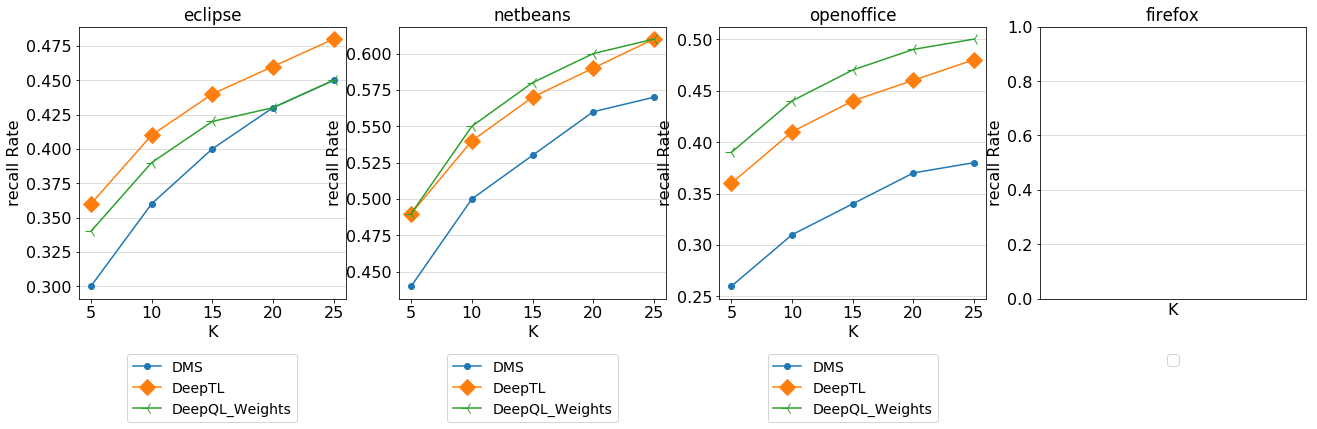

In [8]:
build_100_epochs('recall')

In [9]:
df_100

,recall,precision,f_score,top@k,method,domain,epoch,symbol
0,0.30,0.10,0.15,5,DMS,eclipse,100,.
1,0.36,0.07,0.12,10,DMS,eclipse,100,.
2,0.40,0.06,0.10,15,DMS,eclipse,100,.
3,0.43,0.05,0.09,20,DMS,eclipse,100,.
4,0.45,0.05,0.09,25,DMS,eclipse,100,.
5,0.36,0.11,0.17,5,DeepTL,eclipse,100,D
6,0.41,0.08,0.13,10,DeepTL,eclipse,100,D
7,0.44,0.06,0.11,15,DeepTL,eclipse,100,D
8,0.46,0.05,0.09,20,DeepTL,eclipse,100,D
9,0.48,0.04,0.07,25,DeepTL,eclipse,100,D


## 1000 epochs

In [10]:
df_1000 = df[df['epoch'] == '1000']

In [11]:
import matplotlib.ticker as mticker

MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
def build_1000_epochs(metric):
    # equivalent but more general
    fig, axes = plt.subplots(nrows=1, ncols=len(domains), figsize=(22, 5))

    for index, domain in enumerate(domains):
        aproachs = df['method'].unique()
        for method in aproachs:
            experiment = df_1000[(df_1000['method'] == method) & (df_1000['domain'] == domain)]
            if experiment.shape[0] > 0:
                experiment.plot(x='top@k', y=metric, label=method, ax=axes[index], 
                                marker=experiment['symbol'].values[0], markersize=12)

        axes[index].set_ylabel('{} Rate'.format(metric))
        axes[index].set_xlabel('K')
        text = axes[index].set_title('{}'.format(domain))
        lgd = axes[index].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18))
        formatter = mticker.ScalarFormatter()
        axes[index].xaxis.set_major_formatter(formatter)
        axes[index].xaxis.set_major_locator(mticker.FixedLocator([5, 10, 15, 20, 25]))
        axes[index].grid(True, axis='y', alpha=.5)

    fig.savefig('retrieval_1000.png', bbox_inches="tight")

No handles with labels found to put in legend.


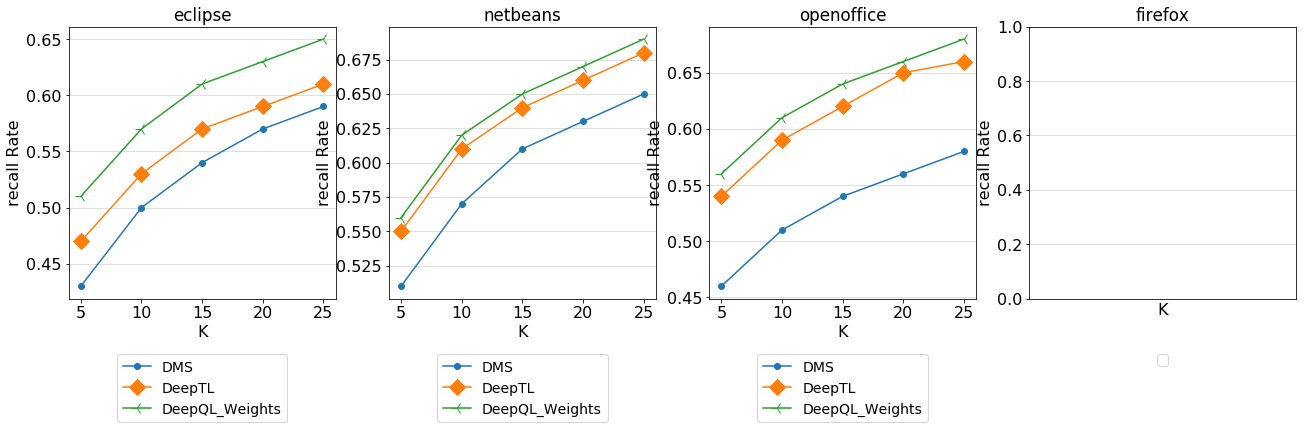

In [12]:
build_1000_epochs('recall')

In [13]:
df_1000

,recall,precision,f_score,top@k,method,domain,epoch,symbol
45,0.43,0.16,0.23,5,DMS,eclipse,1000,.
46,0.50,0.12,0.19,10,DMS,eclipse,1000,.
47,0.54,0.10,0.17,15,DMS,eclipse,1000,.
48,0.57,0.08,0.14,20,DMS,eclipse,1000,.
49,0.59,0.07,0.13,25,DMS,eclipse,1000,.
50,0.47,0.16,0.24,5,DeepTL,eclipse,1000,D
51,0.53,0.11,0.18,10,DeepTL,eclipse,1000,D
52,0.57,0.09,0.16,15,DeepTL,eclipse,1000,D
53,0.59,0.08,0.14,20,DeepTL,eclipse,1000,D
54,0.61,0.07,0.13,25,DeepTL,eclipse,1000,D


In [14]:
import _pickle as pickle

def load_loss(method, base):
    loss_dir = 'data/processed/{}/{}'.format(base, 'bert')
    loss_dir = os.path.join(loss_dir,'{}_log.pkl'.format(method))

    with open(loss_dir, 'rb') as f:
        loss = pickle.load(f)
    return loss

In [15]:
 def validation_loss(loss, val_loss):
        plt.plot(loss, label='loss')
        plt.plot(val_loss, label='val_loss')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
def validation_loss_grid(loss, val_loss, name, lines, col, index):
        ax = plt.subplot(lines, col, index)
        plt.plot(loss, label='loss')
        plt.plot(val_loss, label='val_loss')
        plt.title(name)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.grid(True)
        return ax

In [16]:
def plot_loss(base, epochs, limit_epochs=1000):

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22, 20))

    index_grid = 1
    for row, model in enumerate(['deepQL_weights_{}'.format(epochs),
                                 'deepCL_{}'.format(epochs),
                                 'baseline_{}'.format(epochs),
                                 'DMS_QL_{}'.format(epochs), 
                                 'DWEN_QL_{}'.format(epochs),
                                'deepTL_{}'.format(epochs)]):
        try:
            ql_loss = load_loss(model, base)
            for _, (loss_name, index) in enumerate(zip(['loss', 'TL', 'TL_pos', 'TL_neg', 'TL_centroid'], [0, 5, 6, 7, 8])):
                try:
                    train = [r[index] for r in ql_loss['train']][:limit_epochs]
                    test = [r[index] for r in ql_loss['test']][:limit_epochs]
                    ax_r = validation_loss_grid(train, test, loss_name, n_rows, n_cols, index_grid)
                    if(index_grid == 1 or (index_grid % n_cols == 1)):
                        ax = ax_r
                except: pass
                index_grid+=1
            
            plt.text(0, 1.5, model,
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=ax.transAxes,
                 fontsize=20)
        except:
            pass


    plt.subplots_adjust(hspace=1.25,
                        wspace=0.35)
    plt.show()

In [17]:
n_rows = 5
n_cols = 5
limit_epochs = 200
epochs = 1000

### Eclipse 

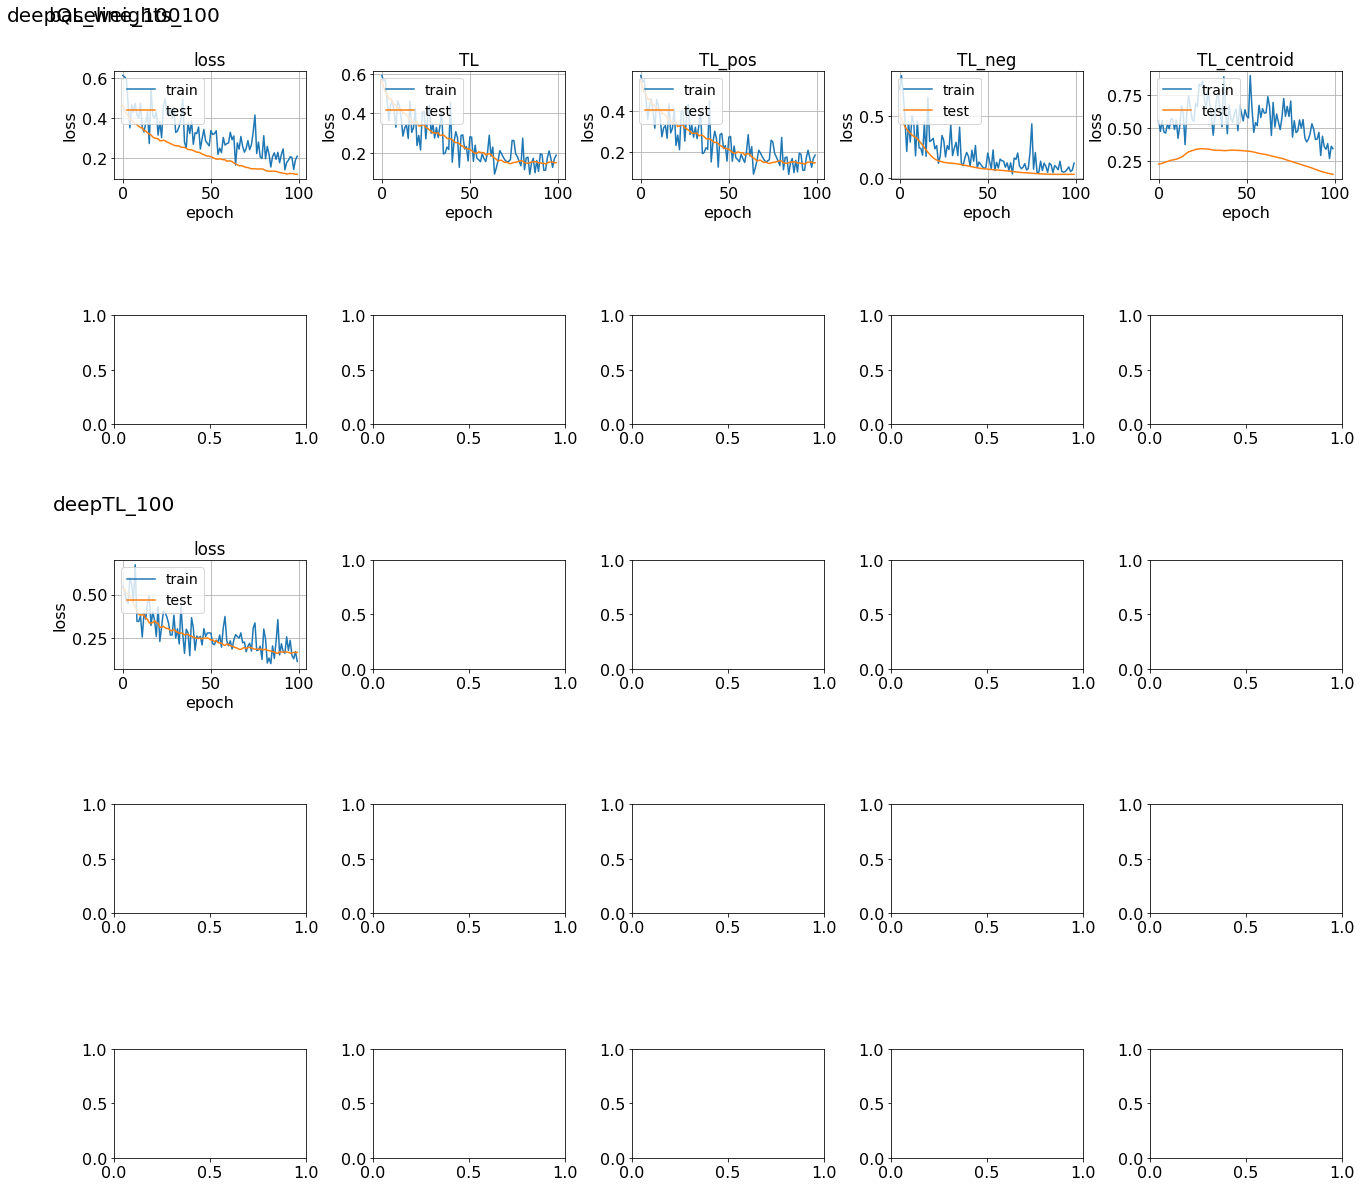

In [18]:
plot_loss('eclipse', 100, limit_epochs=100)

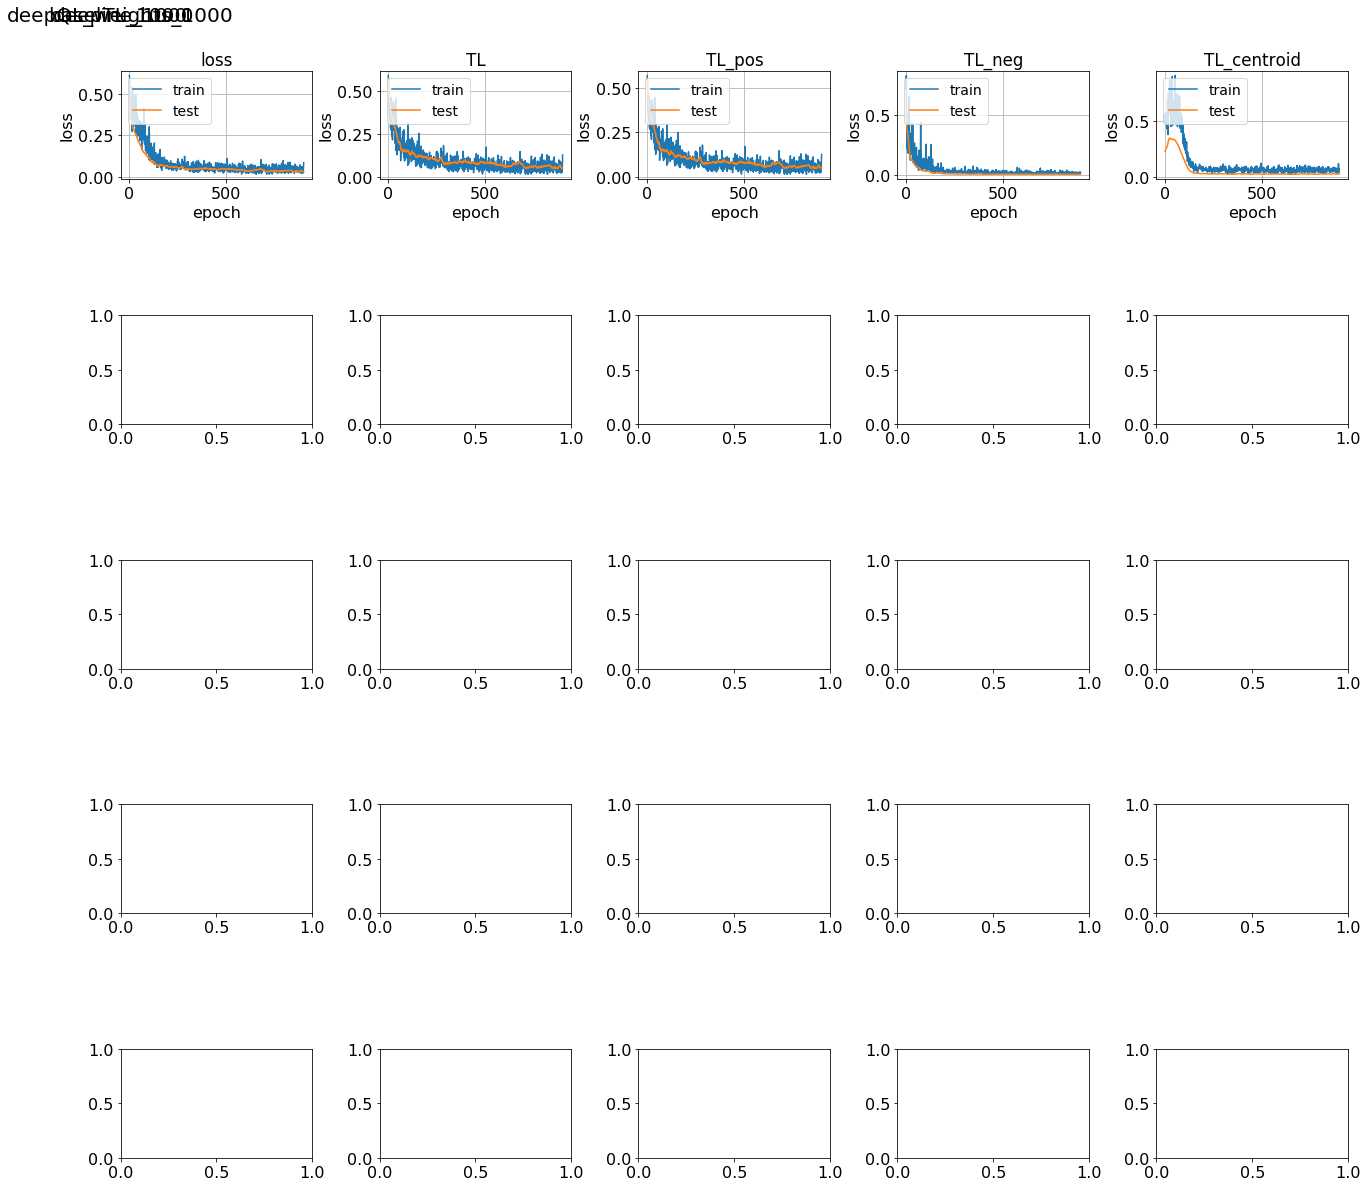

In [19]:
plot_loss('eclipse', 1000)

### Netbeans

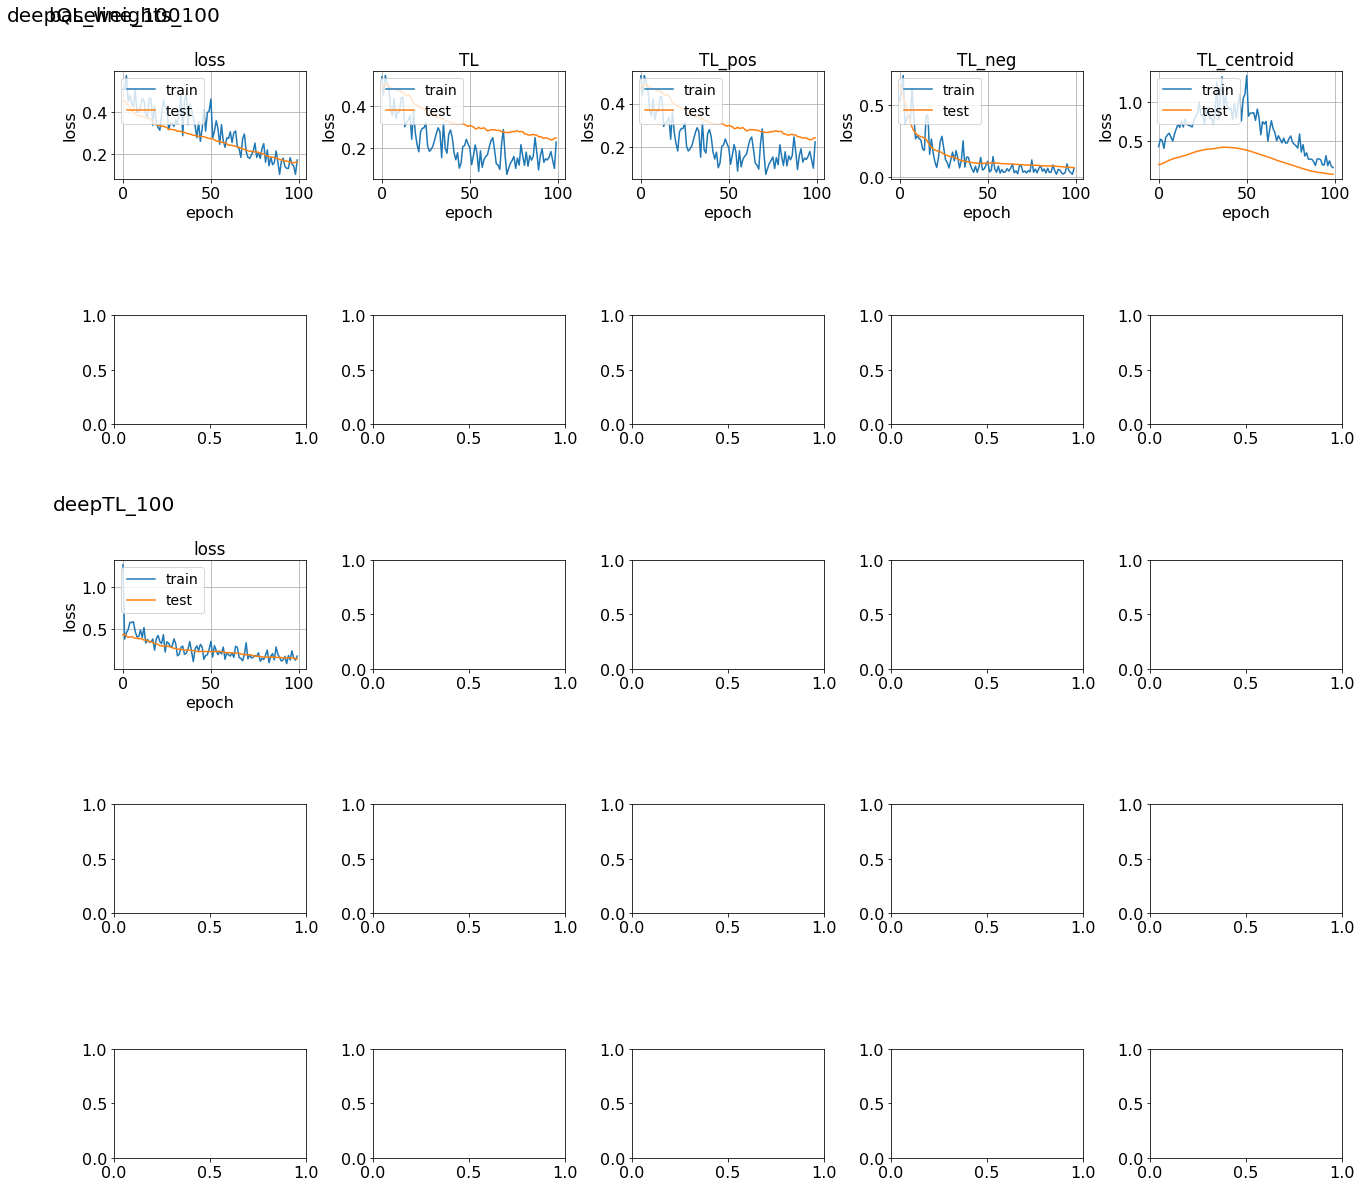

In [20]:
plot_loss('netbeans', 100, limit_epochs=100)

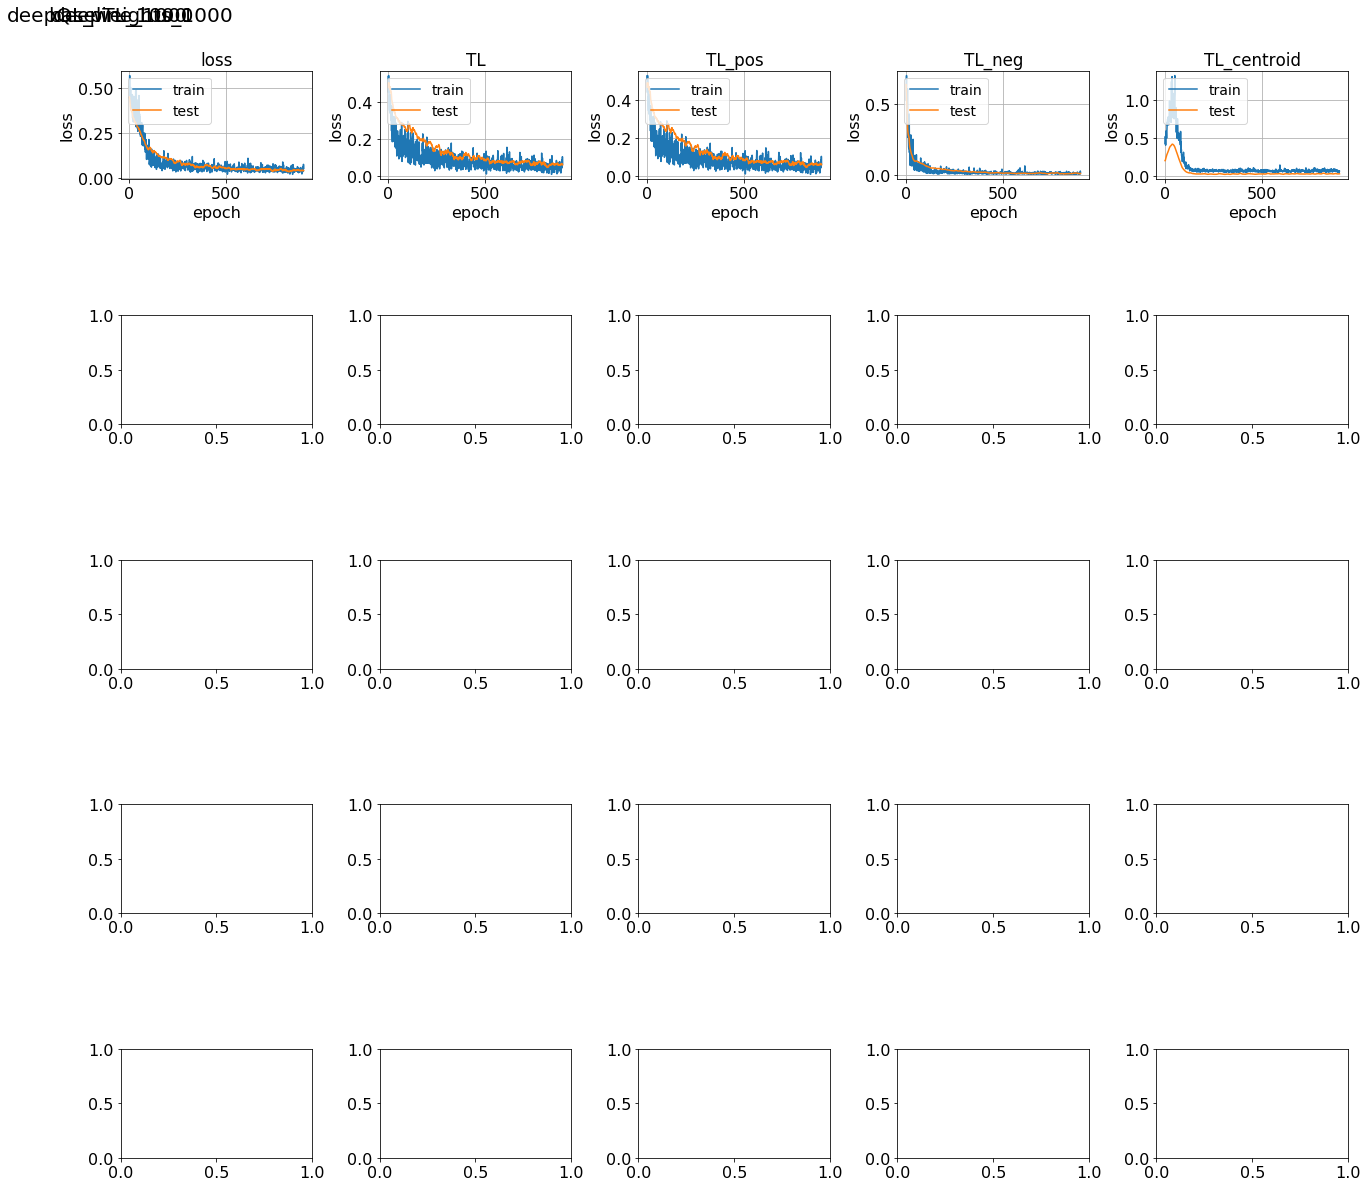

In [21]:
plot_loss('netbeans', epochs)

### Open Office

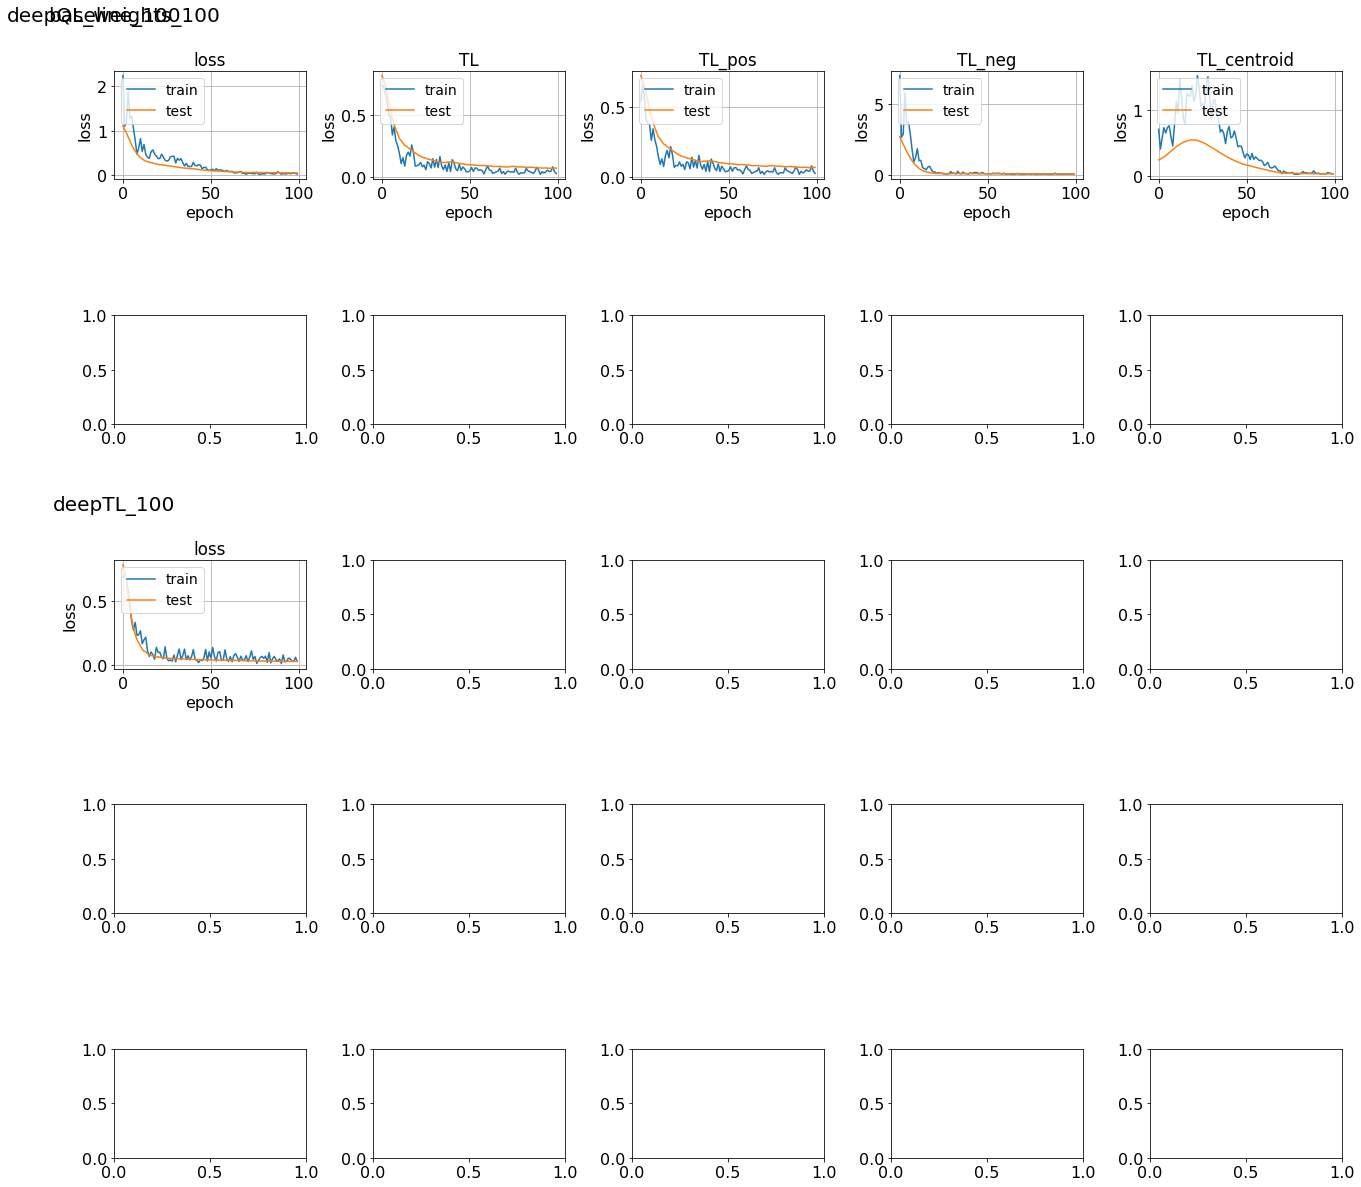

In [22]:
plot_loss('openoffice', 100, limit_epochs=100)

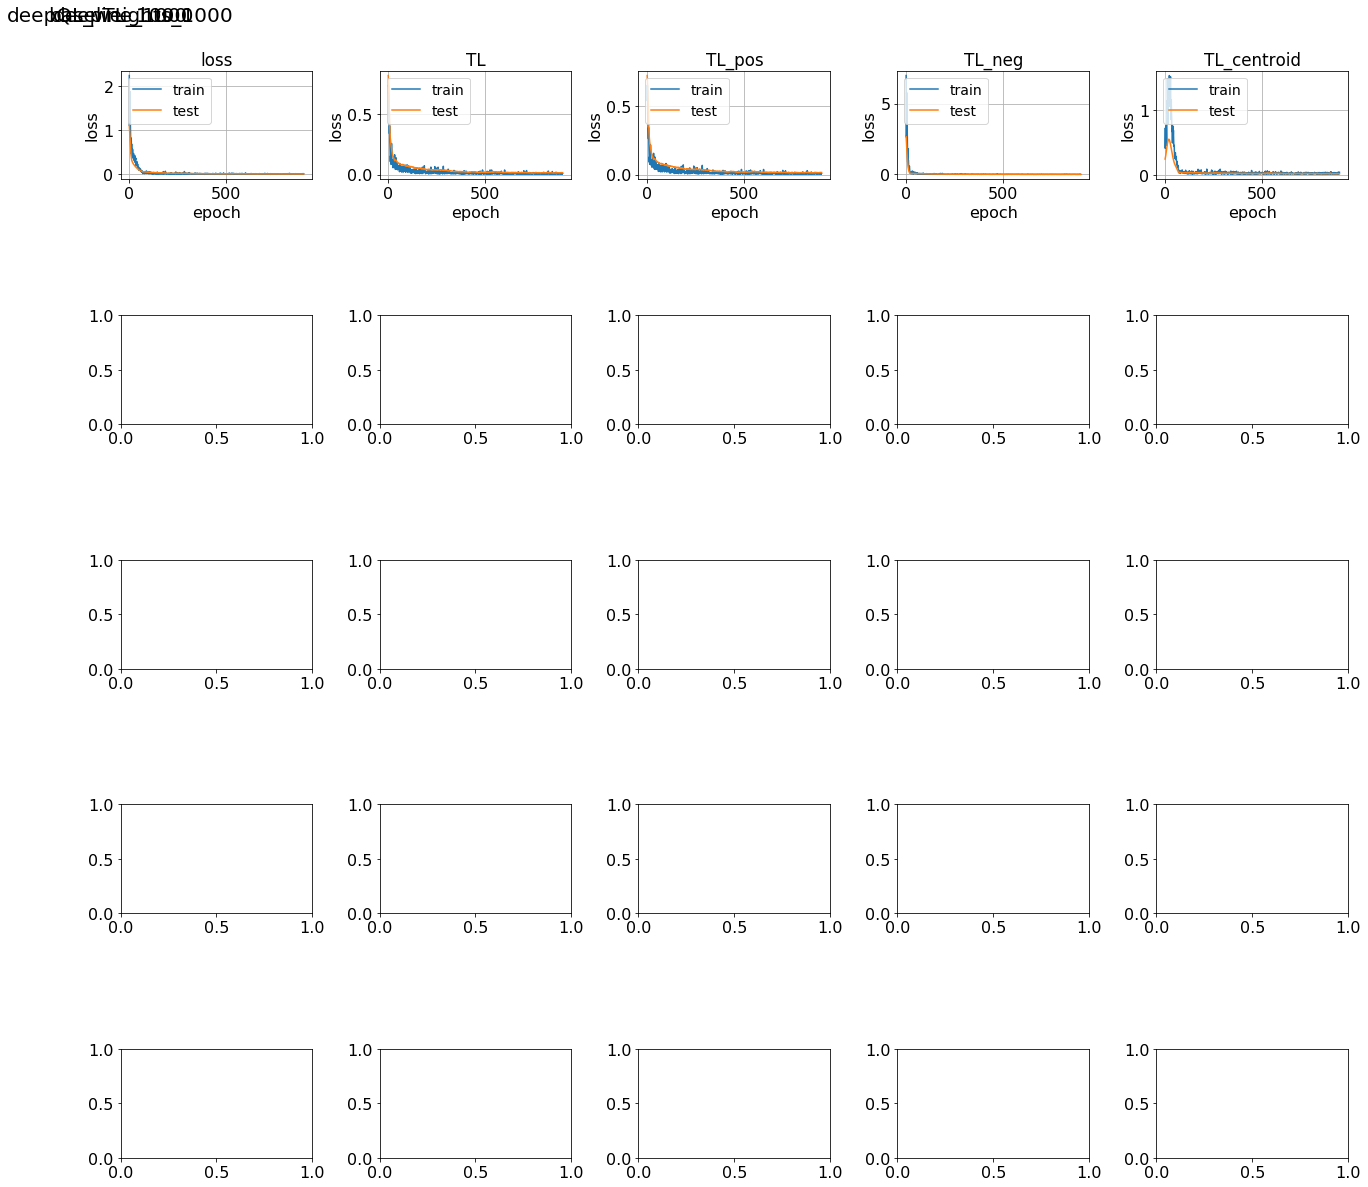

In [23]:
plot_loss('openoffice', 1000)

### Firefox

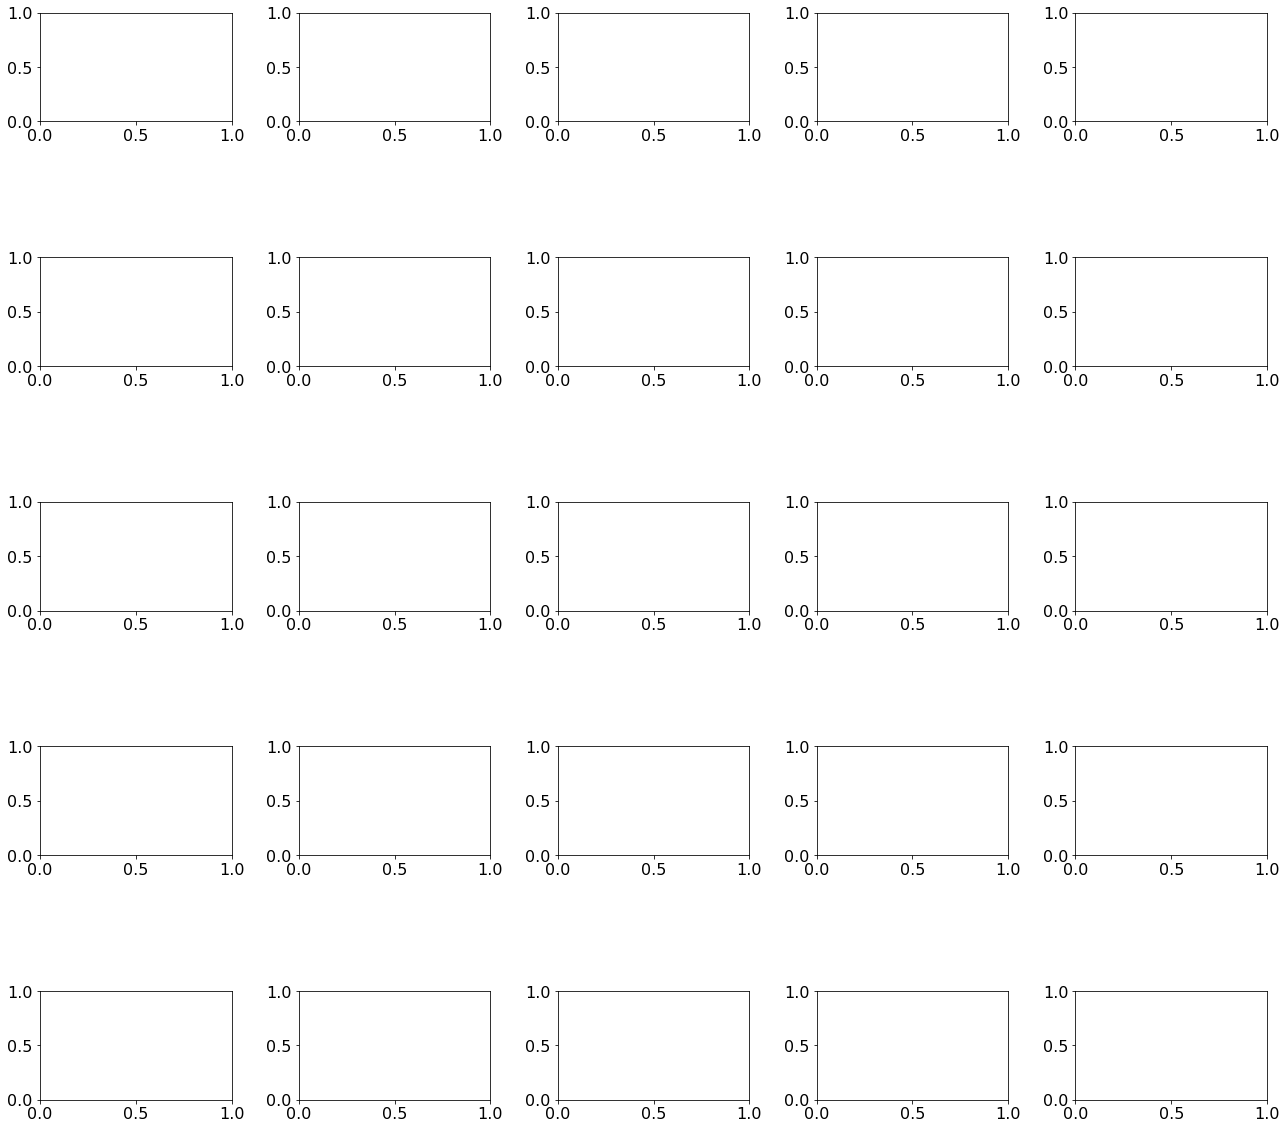

In [24]:
plot_loss('firefox', 100, limit_epochs=100)

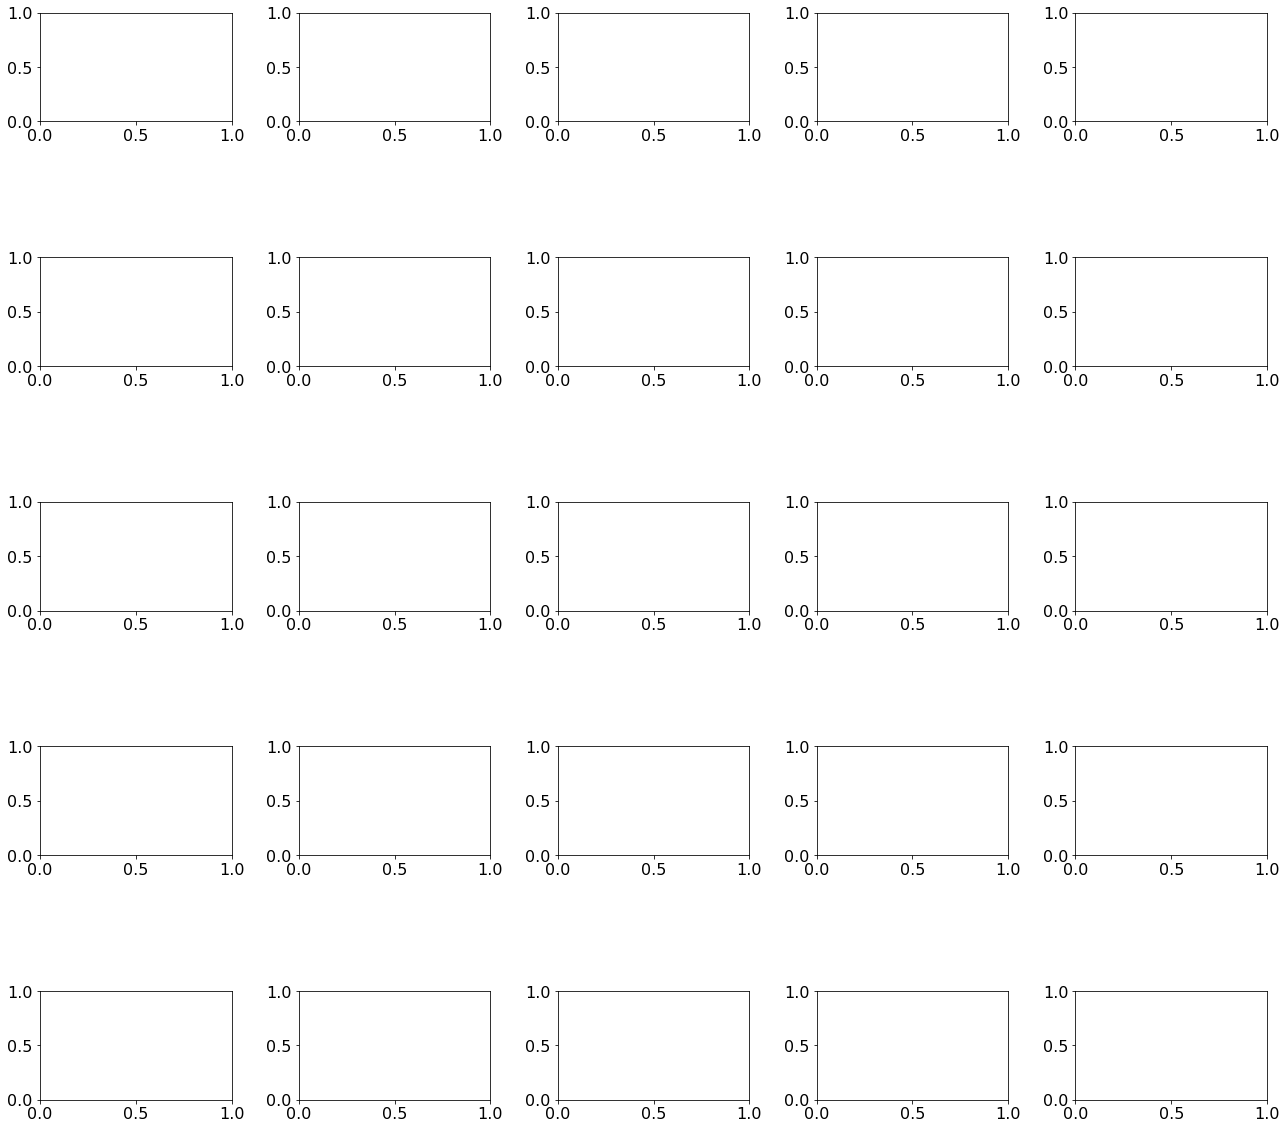

In [25]:
plot_loss('firefox', 1000, limit_epochs=1000)

### How TL is the most important during the learning?

Count how many time a model choiced a loss as the most important loss.

In [26]:
'''
    deepQL_weights_1000
    DMS_QL_1000
    DWEN_QL_1000
    DeepTL_100
'''
ql_loss = load_loss('deepTL_1000', 'eclipse')

In [27]:
len(ql_loss['train'])

900

#### Triplet Loss with weights

In [28]:
ql_loss['train']

[[0.54863286],
 [0.51998395],
 [0.46447405],
 [0.44802442],
 [0.59624666],
 [0.5581866],
 [0.46025017],
 [0.6703789],
 [0.3471452],
 [0.34489253],
 [0.37650302],
 [0.2559266],
 [0.39142928],
 [0.35934484],
 [0.45295265],
 [0.4927094],
 [0.3226581],
 [0.40179217],
 [0.3511678],
 [0.2593446],
 [0.43055084],
 [0.23102279],
 [0.31496513],
 [0.4031566],
 [0.3960152],
 [0.37104508],
 [0.3330878],
 [0.26723906],
 [0.26842782],
 [0.3814658],
 [0.2504374],
 [0.30373493],
 [0.21669327],
 [0.43369606],
 [0.27526328],
 [0.16247219],
 [0.30122373],
 [0.2794266],
 [0.14971398],
 [0.36700737],
 [0.30916217],
 [0.18053347],
 [0.2620915],
 [0.2475182],
 [0.26014328],
 [0.21045353],
 [0.3041496],
 [0.25958458],
 [0.27945837],
 [0.28001305],
 [0.27857402],
 [0.21755312],
 [0.21267635],
 [0.23846819],
 [0.226294],
 [0.26753756],
 [0.19782592],
 [0.3079109],
 [0.37389407],
 [0.2340873],
 [0.20591229],
 [0.23462583],
 [0.18728118],
 [0.23904812],
 [0.27015385],
 [0.25884822],
 [0.24938665],
 [0.27998212],
 

ValueError: setting an array element with a sequence.

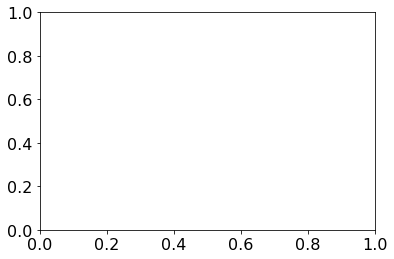

In [29]:
train = [r for r in ql_loss['train']]
test = [r for r in ql_loss['test']]
validation_loss(train, test)

#### Triplet loss

In [ ]:
train = [r[5] for r in ql_loss['train']][:limit_epochs]
test = [r[5] for r in ql_loss['test']][:limit_epochs]

validation_loss(train, test)

#### Triplet loss pos

In [ ]:
train = [r[6] for r in ql_loss['train']]
test = [r[6] for r in ql_loss['test']]

validation_loss(train, test)

#### Triplet loss neg

In [ ]:
train = [r[7] for r in ql_loss['train']]
test = [r[7] for r in ql_loss['test']]

validation_loss(train, test)

#### Triplet loss centroids

In [ ]:
train = [r[8] for r in ql_loss['train']]
test = [r[8] for r in ql_loss['test']]

validation_loss(train, test)

### Classification

In [ ]:
import _pickle as pickle

rows = []

for epoch in ['100', '1000']:
    for domain in domains:
        # Dataset paths
        DIR = 'data/processed/{}/{}/'.format(domain, PREPROCESSING)

        for method in methods[epoch]:
            path = os.path.join(DIR, 'classification_{}.pkl'.format(method))

            try:
                with open(path, 'rb') as f:
                    result = pickle.load(f)

                print(path)

                rows.append({ 'autor': authors[result['method']], 'acurácia' : result['acc_test'], 'roc/auc' : result['roc_test'],  
                             'domain' : domain })
            except:
                print("Does not exist result for: {}".format(path))
                pass
    
df_cls = pd.DataFrame(data=rows, columns=['autor', 'acurácia', 'roc/auc', 'domain'])

In [ ]:
fig, axes = plt.subplots(nrows=len(domains), ncols=2, figsize=(15, 15))

for row, domain in enumerate(domains): 
    plt.text(1.15, 1.08, domain,
         horizontalalignment='center',
         fontsize=20,
         transform = axes[row, 0].transAxes)
    ax = df_cls[df_cls['domain'] == domain].set_index('autor')[['acurácia']].plot.barh(ax=axes[row, 0])
    #ax.set_title(domain)
    ax = df_cls[df_cls['domain'] == domain].set_index('autor')[['roc/auc']].plot.barh(ax=axes[row, 1], color='g')
    ax.get_yaxis().set_visible(False)
    #ax.set_title(domain)
    
plt.subplots_adjust(hspace=0.55,
                    wspace=0.35)